# Motivation

Here we will take a look at two relatively simple, low-dimensional datasets for which we want to construct models to better understand them.

The first is a case where we want to understand and predict a *quantity* from some data (regression),
the second is where we want to understand and predict a *category* from some data (classification).

## Simple machine learning: regression

We begin by importing some python libraries that we will be using:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('seaborn')

import warnings
warnings.filterwarnings("ignore")

Imagine we have a noisy quadratic dataset. We can construct such data synthetically by the following function, which takes some inputs and returns a line with some normally distributed error:

In [2]:
def generate_samples(x):
    return x*x + np.random.normal(0.0, 4, size=len(x))

We can then use this to generate our points. This will be the data to which we fit our machine learning model (i.e., the training data):

In [3]:
xtrain = np.random.uniform(low=0, high=10, size=10)
ytrain = generate_samples(xtrain)

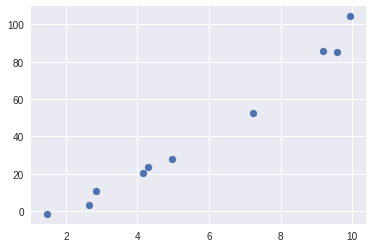

In [4]:
plt.scatter(xtrain,ytrain)

A simple model for fitting 1D data is to fit a n-degree polynomial through that data.
Such a polynomial has the form
$$
f(x) = a_0 + a_1 x^1 + a_2 x^2 ... + a_n x^n
$$
The task at hand is to find the $a_i$ such that the resulting curve minimizes the distance to the training data.
Fortunately, numpy has a function `polyfit` to do just that.

The following function fits the data to a polynomial of degree `degree`
and plots the resulting curve:

In [5]:
def plot_fit(degree, xtest=None, ytest=None):
    p = np.polyfit(xtrain,ytrain,degree)
    xfit = np.linspace(0, 10, 1000)
    yfit = np.polyval(p, xfit)
    plt.plot(xfit, yfit)
    plt.scatter(xtrain, ytrain, label='training')
    if xtest is not None and ytest is not None:
        plt.scatter(xtest, ytest, c='maroon', label='testing')
    plt.xlim(0,10)
    plt.ylim(-20, 150)
    plt.legend(loc='upper left')

We can make this interactive by using `ipywidgets`:

In [6]:
from ipywidgets import interact, widgets
interact(lambda degree: plot_fit(degree), degree=widgets.IntSlider(min=1,max=10,step=1,value=1))

interactive(children=(IntSlider(value=1, description='degree', max=10, min=1), Output()), _dom_classes=('widge…

<function __main__.<lambda>(degree)>

Play with the polynomial degree to see how well different degrees fit the data.
We can see that as we increase the degree of the model, we obtain a better and better fit.
At degree 10, the model goes through *all* the points.
So does that mean that the degree 10 model is the best model?

Probably not: let's see what happens if we test the model on some data that was *not* used to train it.
This process is known as validation.
First, we generate the validation (or test) data, then
we replot the fit.

In [7]:
xtest = np.random.uniform(low=0, high=10, size=10)
ytest = generate_samples(xtest)
interact(lambda degree: plot_fit(degree, xtest, ytest), degree=widgets.IntSlider(min=1,max=10,step=1,value=1))

interactive(children=(IntSlider(value=1, description='degree', max=10, min=1), Output()), _dom_classes=('widge…

<function __main__.<lambda>(degree)>

We can see that at low degrees the fit remains fairly close to the test data.
But at higher degrees, when the curve starts to oscillate wildly,
the fit for the validation data does *very badly*, even though it is nailing the test data!

# Motivation: classification

Above we wanted our model to predict a *quantity* from the data.
There are also many cases where we will want to predict a *class* or *type* from the data.
This is known as a classification problem.

As before, we make a few relevant imports:

In [8]:
from scipy.spatial import KDTree
from scipy.stats import multivariate_normal

Again, we will generate some synthetic data.
The following function generates blobs of points in 2D space
with normal distributions:

In [9]:
def generate_blob(mean, scale=1, size=10):
    data = multivariate_normal.rvs(mean, cov=scale, size=size)
    x = data[:,0]
    y = data[:,1]
    return x,y

We can use this to generate three blobs with different centers:

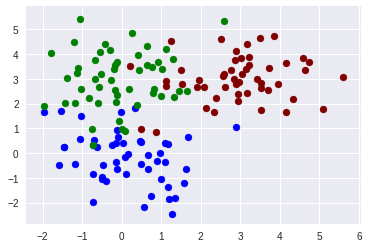

In [10]:
x1, y1 = generate_blob([0,0], scale=1, size=50)
x2, y2 = generate_blob([3,3], scale=1, size=50)
x3, y3 = generate_blob([0,3], scale=1, size=50)
plt.scatter(x1, y1, c='blue')
plt.scatter(x2, y2, c='maroon')
plt.scatter(x3, y3, c='green')

Given some new data, can we predict which of the blobs it might be drawn from?
Among the simplest approaches to this question is to use a nearest neighbor classifier.
We go through the training data and find the point to which a new datum is the closest.
The new datum is then assigned to the class of that neighbor.

The following python class has two functions, `fit`, and `predict`.
The first fits the model on the training blobs,
and the second classifies new data according to the nearest neighbor criterion:

In [11]:
class NearestNeighborClassifier:
    
    def fit(self, blobs):
        self._trees = []
        for blob in blobs:
            self._trees.append(KDTree(np.array(blob).T))
            
    def predict(self, data):
        classification = np.zeros(len(data))
        for i,d in enumerate(data):
            distances = [tree.query(d)[0] for tree in self._trees]
            classification[i] = np.argmin(distances)
        return classification

We can now use the classifier on our training data:

In [12]:
classifier = NearestNeighborClassifier()
classifier.fit([[x1,y1], [x2,y2], [x3,y3]])

With the model now fit to the training data, we can iterate over a 2D domain
and determine to which class each point is assigned:

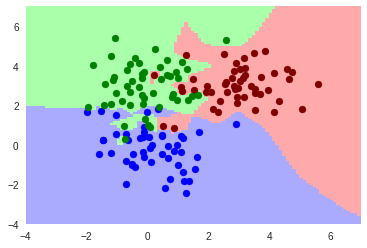

In [13]:
from matplotlib.colors import ListedColormap

def plot_nn():
    cmap = ListedColormap([  '#AAAAFF','#FFAAAA','#AAFFAA'])

    x_min, x_max = -4, 7
    y_min, y_max = -4, 7
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap)

    # Plot also the training points
    plt.scatter(x1, y1, c='blue')
    plt.scatter(x2, y2, c='maroon')
    plt.scatter(x3, y3, c='green')
    plt.axis('tight')
plot_nn()

You can see that the broad strokes of the model do a pretty good job in assigning points to the right cluster,
but there are some causes for concern.
The boundaries between the regions are fairly jagged,
and there are some islands that don't reflect the underlying "physics".

These are some general problems with such a simple classifier:
the problem is overfit.

## Moving forward

These two motivating problems showed some relatively simple machine learning models,
but they also showed some limitations of the models.
A naive model can easily overfit or underfit the data,
or can be from a class of models that is not suited to the underlying dataset.

We would like to bring some more robust tools to bear on such problems,
including the ability to test many model classes,
conduct cross-validation, and score models according to their performance.
The de facto standard library for python machine learning, scikit-learn,
provides these and much more.